# GAN (Generative Adverserial Networks)
    In this notebook, a report for a GAN implementation is documented.

### Vision & Background

The GAN is consisted of a generator network and a discriminator network where the two networks compete with each other. While the generator producing counterfeit data from the given original data, the discriminator tries to distinguish the counterfeit version from the original version. As these two networks' competition repeats, we would have the generator keep getting better at producing higher quality of counterfeits, and we also would have the discriminator keep getting better at detecting counterfeit data. The architecture of the generator and the discriminator are further explained below along with the corresponding codes.

When we have a GAN successfully trained, we could theoretically augment the data that in its nature, it is hard to acquire in large quantity by utilizing the generator part of the GAN. 


### Frog Model

This overview takes the codes from Chapter 8, Section 5 of Deep Learning with Python by Chollet. It includes 3 parts: the generator development, the discriminator development, and the adversarial network. Also for ease of implementation, the data used is some image data.

### The Generator

The architecture of the generator in this example is pretty complicated. According to Chollet, one of the most popular issues with GAN is that the generator gets studck with those images that look like noise. To prevent this from happening, we could use dropout on both the generator and the discriminator, which in this case we will set the droupout rate at 0.4.

In [1]:
import keras
from keras import layers
import numpy as np


latent_dim = 32
height = 32
width = 32
channels = 3

generator_input = keras.Input(shape=(latent_dim,))

# First, transform the input into a 16x16 128-channels feature map
x = layers.Dense(128 * 16 * 16)(generator_input)
# x = layers.BatchNormalization(momentum = 0.9)(x)
x = layers.LeakyReLU()(x)
x = layers.Reshape((16, 16, 128))(x)
# x = layers.Dropout(0.4)(x)

# Then, add a convolution layer
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

# Upsample to 32x32
x = layers.Conv2DTranspose(256, 4, strides=2, padding='same')(x)
x = layers.LeakyReLU()(x)

# Few more conv layers
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

# Produce a 32x32 1-channel feature map
x = layers.Conv2D(channels, 7, activation='tanh', padding='same')(x)
generator = keras.models.Model(generator_input, x)
generator.summary()


Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32768)             1081344   
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32768)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 256)       819456    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16, 16, 256)       0         
_________________________________________________________________
conv

### The Discriminator

The discriminator model in GAN is pretty much a DNN classification model. It takes the outputs from the generator which are mixed with the real images that are used to generate fake images, and output the performance value measured as the accuracy. Essentially, the dsicriminator and the generator are the inverses of each other, the generator would use down-sampling and the discriminator would use up-sampling in the convolution processes. Also, as the discriminator is the inverse of the generator, the discriminator would not use max-pooling in up-sampling but use 2D-convolution instead. 

In [2]:
discriminator_input = layers.Input(shape=(height, width, channels))
x = layers.Conv2D(128, 3)(discriminator_input)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Flatten()(x)

# One dropout layer
x = layers.Dropout(0.4)(x)

# Classification layer
x = layers.Dense(1, activation='sigmoid')(x)

discriminator = keras.models.Model(discriminator_input, x)
discriminator.summary()

# To stabilize training, we use learning rate decay
# and gradient clipping (by value) in the optimizer.
discriminator_optimizer = keras.optimizers.RMSprop(lr=0.0008, clipvalue=1.0, decay=1e-8)
discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy')

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 30, 30, 128)       3584      
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 6, 6, 128)         262272    
___________________________

### TheAdversarial Network

When setting up the GAN, we must set discriminator.trainable = False, because we are trying to train the generator to produce more "real" data that would make the discriminator guess the counterfeit version as "real." If we allow discriminator to be trainable, then the GAN would change the weights of discriminator to classify the data produced by generator as "real" regardless of whether input data is counterfeit or not. 

In [3]:
# Set discriminator weights to non-trainable
discriminator.trainable = False

gan_input = keras.Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))
gan = keras.models.Model(gan_input, gan_output)

gan_optimizer = keras.optimizers.RMSprop(lr=0.0004, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')

### Training DCGAN

DCGAN stands for deep convolutional generative adversarial network. The training of the DCGAN follows these steps:

    for each epoch:
        - pick a random point in the latent space
        - generate images with the generator by applying the random noise on the random point we just picked
        mix the generated images with the real ones
        - train the discriminator using the mixed images
        - pick a new randompoint in the latent space
        - train the GAN with random vectors, targeting to make this GAN to label all images as "real".
        
**important** 
The last line says to make all images real, it would update the weights of the generator not of the discriminator since we disabled the discriminator training. Also, the training process takes a long time. As the number of iterations increase, usually the quality of the generated images also gets better. However, due to the time constraint, the number of iterations was set at 200 as opposed to the 100,000 iterations used in the Chollet's demonstration. 

In [4]:
import os
from keras.preprocessing import image

# Load CIFAR10 data
(x_train, y_train), (_, _) = keras.datasets.cifar10.load_data()

# Select frog images (class 6)
x_train = x_train[y_train.flatten() == 6]


# Show the image infomation
print("Number of images for training:", x_train.shape[0])
print("Number of images used for testing:", y_train.shape[0])
pix = int(np.sqrt(x_train.shape[1]))
print("Each image is:", pix, "by", pix, "pixels")

# Normalize data
x_train = x_train.reshape(
    (x_train.shape[0],) + (height, width, channels)).astype('float32') / 255.

Number of images for training: 5000
Number of images used for testing: 50000
Each image is: 5 by 5 pixels


In [5]:
iterations = 200
batch_size = 10
save_dir = os.getcwd()

# Start training loop
start = 0
for step in range(iterations):
    # Sample random points in the latent space
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

    # Decode them to fake images
    generated_images = generator.predict(random_latent_vectors)

    # Combine them with real images
    stop = start + batch_size
    real_images = x_train[start: stop]
    combined_images = np.concatenate([generated_images, real_images])

    # Assemble labels discriminating real from fake images
    labels = np.concatenate([np.ones((batch_size, 1)),
                             np.zeros((batch_size, 1))])
    # Add random noise to the labels - important trick!
    labels += 0.05 * np.random.random(labels.shape)

    # Train the discriminator
    d_loss = discriminator.train_on_batch(combined_images, labels)

    # sample random points in the latent space
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

    # Assemble labels that say "all real images"
    misleading_targets = np.zeros((batch_size, 1))

    # Train the generator (via the gan model,
    # where the discriminator weights are frozen)
    a_loss = gan.train_on_batch(random_latent_vectors, misleading_targets)
    
    start += batch_size
    if start > len(x_train) - batch_size:
        start = 0

    # Occasionally save / plot
    if step % 100 == 0:
        # Save model weights
        gan.save_weights('gan.h5')

        # Print metrics
        print('discriminator loss at step %s: %s' % (step, d_loss))
        print('adversarial loss at step %s: %s' % (step, a_loss))

        # Save one generated image
        img = image.array_to_img(generated_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir, 'generated_frog' + str(step) + '.png'))

        # Save one real image, for comparison
        img = image.array_to_img(real_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir, 'real_frog' + str(step) + '.png'))

Instructions for updating:
Use tf.cast instead.


/home/hj35/.local/lib/python3.5/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


discriminator loss at step 0: 0.69919103
adversarial loss at step 0: 0.65845364
discriminator loss at step 100: 0.69479656
adversarial loss at step 100: 0.7233832


### The Results

The below is the images generated by the generator:

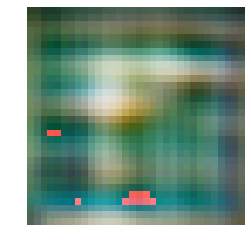

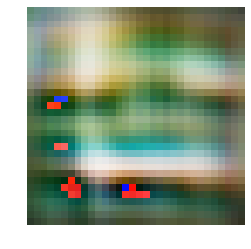

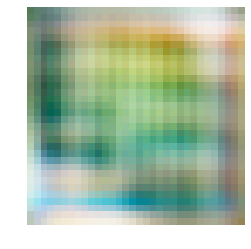

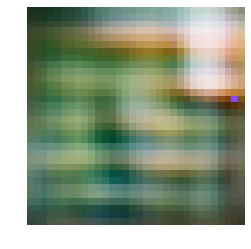

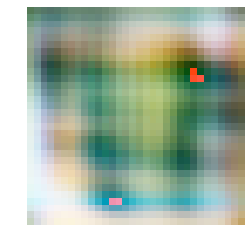

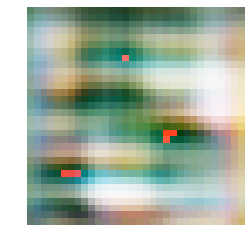

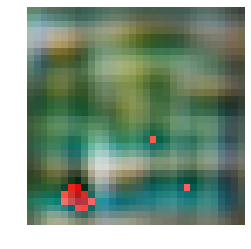

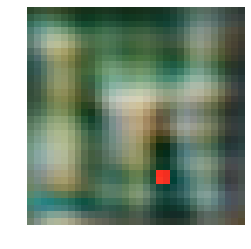

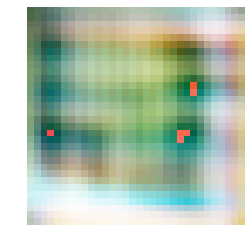

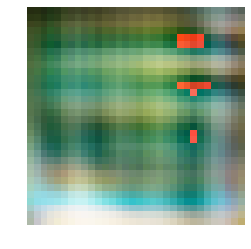

In [7]:
import matplotlib.pyplot as plt

# Sample random points in the latent space
random_latent_vectors = np.random.normal(size=(10, latent_dim))

# Decode them to fake images
generated_images = generator.predict(random_latent_vectors)

for i in range(generated_images.shape[0]):
    img = image.array_to_img(generated_images[i] * 255., scale=False)
    plt.figure()
    plt.imshow(img)
    plt.axis('off')
    
plt.show()

### MNIST: Different Model

The plots generated by the previous frog GAN doesn't seem very satisfying. Using a different GAN, MNIST dataset is fit. The dataset is taken from the famous MNIST hand-written digit images. Since the representation of the frog images was not satisfactory with small number of iterations, by reducing the complexity of the images, I could try generating better quality of images produced by the generator. I suspect that the design of the model is somehow incompatible with the new set of data that has different image dimensions from the frog images. Therefore, I implmented another GAN model that's created by Rowel Atienza who designed the GAN architecture to apply it in generating MNIST dataset. The notable differences between this model and the previous frog model are as follow:
    1. Each convolution step takes different depth, propagating in multiples of 2.
    2. In the generator, ReLU activation function is used instead of LeakReLU.
    3. In the generator, at each step of upsampling, the batch normalization is applied.
    4. In the discriminator, the dropout() is applied at each step of convolution.
    

In [8]:
import numpy as np
import time
from tensorflow.examples.tutorials.mnist import input_data

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Reshape
from keras.layers import Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers import LeakyReLU, Dropout
from keras.layers import BatchNormalization
from keras.optimizers import Adam, RMSprop

import matplotlib.pyplot as plt

class ElapsedTimer(object):
    def __init__(self):
        self.start_time = time.time()
    def elapsed(self,sec):
        if sec < 60:
            return str(sec) + " sec"
        elif sec < (60 * 60):
            return str(sec / 60) + " min"
        else:
            return str(sec / (60 * 60)) + " hr"
    def elapsed_time(self):
        print("Elapsed: %s " % self.elapsed(time.time() - self.start_time) )

class DCGAN(object):
    def __init__(self, img_rows=28, img_cols=28, channel=1):

        self.img_rows = img_rows
        self.img_cols = img_cols
        self.channel = channel
        self.D = None   # discriminator
        self.G = None   # generator
        self.AM = None  # adversarial model
        self.DM = None  # discriminator model

    # (W−F+2P)/S+1
    def discriminator(self):
        if self.D:
            return self.D
        self.D = Sequential()
        depth = 64
        dropout = 0.4
        # In: 28 x 28 x 1, depth = 1
        # Out: 14 x 14 x 1, depth=64
        input_shape = (self.img_rows, self.img_cols, self.channel)
        self.D.add(Conv2D(depth*1, 5, strides=2, input_shape=input_shape,\
            padding='same'))
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(dropout))

        self.D.add(Conv2D(depth*2, 5, strides=2, padding='same'))
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(dropout))

        self.D.add(Conv2D(depth*4, 5, strides=2, padding='same'))
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(dropout))

        self.D.add(Conv2D(depth*8, 5, strides=1, padding='same'))
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(dropout))

        # Out: 1-dim probability
        self.D.add(Flatten())
        self.D.add(Dense(1))
        self.D.add(Activation('sigmoid'))
        self.D.summary()
        return self.D

    def generator(self):
        if self.G:
            return self.G
        self.G = Sequential()
        dropout = 0.4
        depth = 64+64+64+64
        dim = 7
        # In: 100
        # Out: dim x dim x depth
        self.G.add(Dense(dim*dim*depth, input_dim=100))
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(Activation('relu'))
        self.G.add(Reshape((dim, dim, depth)))
        self.G.add(Dropout(dropout))

        # In: dim x dim x depth
        # Out: 2*dim x 2*dim x depth/2
        self.G.add(UpSampling2D())
        self.G.add(Conv2DTranspose(int(depth/2), 5, padding='same'))
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(Activation('relu'))

        self.G.add(UpSampling2D())
        self.G.add(Conv2DTranspose(int(depth/4), 5, padding='same'))
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(Activation('relu'))

        self.G.add(Conv2DTranspose(int(depth/8), 5, padding='same'))
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(Activation('relu'))

        # Out: 28 x 28 x 1 grayscale image [0.0,1.0] per pix
        self.G.add(Conv2DTranspose(1, 5, padding='same'))
        self.G.add(Activation('sigmoid'))
        self.G.summary()
        return self.G

    def discriminator_model(self):
        if self.DM:
            return self.DM
        optimizer = RMSprop(lr=0.0002, decay=6e-8)
        self.DM = Sequential()
        self.DM.add(self.discriminator())
        self.DM.compile(loss='binary_crossentropy', optimizer=optimizer,\
            metrics=['accuracy'])
        return self.DM

    def adversarial_model(self):
        if self.AM:
            return self.AM
        optimizer = RMSprop(lr=0.0001, decay=3e-8)
        self.AM = Sequential()
        self.AM.add(self.generator())
        self.AM.add(self.discriminator())
        self.AM.compile(loss='binary_crossentropy', optimizer=optimizer,\
            metrics=['accuracy'])
        return self.AM

class MNIST_DCGAN(object):
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channel = 1

        self.x_train = input_data.read_data_sets("mnist",\
        	one_hot=True).train.images
        self.x_train = self.x_train.reshape(-1, self.img_rows,\
        	self.img_cols, 1).astype(np.float32)

        self.DCGAN = DCGAN()
        self.discriminator =  self.DCGAN.discriminator_model()
        self.adversarial = self.DCGAN.adversarial_model()
        self.generator = self.DCGAN.generator()

    def train(self, train_steps=2000, batch_size=256, save_interval=0):
        noise_input = None
        if save_interval>0:
            noise_input = np.random.uniform(-1.0, 1.0, size=[16, 100])
        for i in range(train_steps):
            images_train = self.x_train[np.random.randint(0,
                self.x_train.shape[0], size=batch_size), :, :, :]
            noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
            images_fake = self.generator.predict(noise)
            x = np.concatenate((images_train, images_fake))
            y = np.ones([2*batch_size, 1])
            y[batch_size:, :] = 0
            d_loss = self.discriminator.train_on_batch(x, y)

            y = np.ones([batch_size, 1])
            noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
            a_loss = self.adversarial.train_on_batch(noise, y)
            if i % 100 == 0:
                log_mesg = "%d: [D loss: %f, acc: %f]" % (i, d_loss[0], d_loss[1])
                log_mesg = "%s  [A loss: %f, acc: %f]" % (log_mesg, a_loss[0], a_loss[1])
                print(log_mesg)
            if save_interval>0:
                if (i+1)%save_interval==0:
                    self.plot_images(save2file=True, samples=noise_input.shape[0],\
                        noise=noise_input, step=(i+1))

    def plot_images(self, save2file=False, fake=True, samples=16, noise=None, step=0):
        filename = 'mnist.png'
        if fake:
            if noise is None:
                noise = np.random.uniform(-1.0, 1.0, size=[samples, 100])
            else:
                filename = "mnist_%d.png" % step
            images = self.generator.predict(noise)
        else:
            i = np.random.randint(0, self.x_train.shape[0], samples)
            images = self.x_train[i, :, :, :]

        plt.figure(figsize=(10,10))
        for i in range(images.shape[0]):
            plt.subplot(4, 4, i+1)
            image = images[i, :, :, :]
            image = np.reshape(image, [self.img_rows, self.img_cols])
            plt.imshow(image, cmap='gray')
            plt.axis('off')
        plt.tight_layout()
        if save2file:
            plt.savefig(filename)
            plt.close('all')
        else:
            plt.show()

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting mnist/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting mnist/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting mnist/t10k-images-idx3-ubyte.gz
Extracting mnist/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_18 (LeakyReLU)   (None, 14, 14, 64)        0 

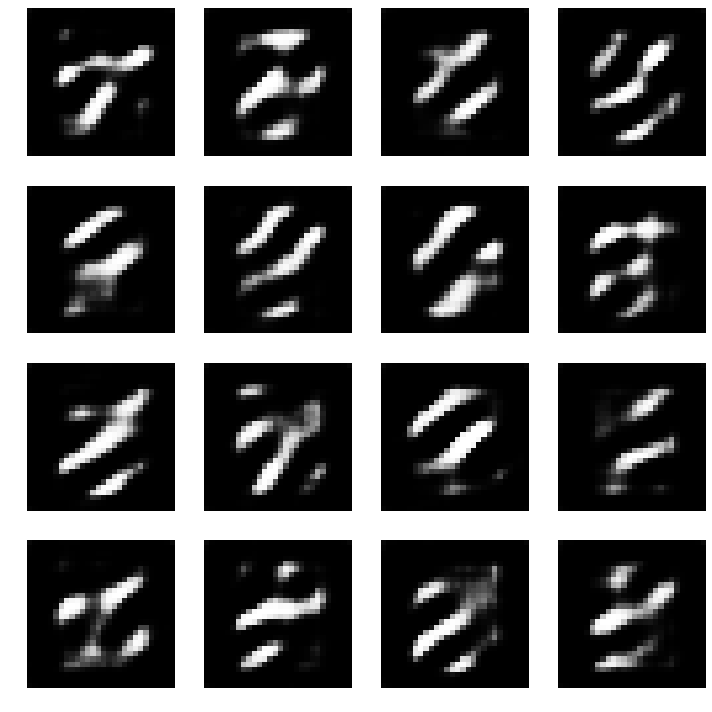

In [19]:
mnist_dcgan = MNIST_DCGAN()
timer = ElapsedTimer()
mnist_dcgan.train(train_steps=200, batch_size=10, save_interval=100)
timer.elapsed_time()
mnist_dcgan.plot_images(fake=True)
mnist_dcgan.plot_images(fake=False, save2file=True)

### MNIST Different Architecture Results

The images generated in this model has bad quality as the digits generated are not recognizable. However, the output images are somewhat defined with edges and the background, which might not was the case in the previous example. Therefore, the architecture seemed better fitting to MNIST dataset than to frog dataset, as the dimensions and the depth are applied differently in the MNIST model.

### Combined Example with MNIST Dataset

To gain some benefits from the previous model and the frog model, I took the architecture from the previous MNIST model combined with the frog model's architecture. Among all 10 digits, I chose "1" as it looks like to be the simplest digit to be shown. Since the image dimensions are different, some adjustments were made. 

In [9]:
from keras.datasets import mnist
import numpy as np
import os
from keras.preprocessing import image

(x_train1, y_train1), (x_test1, y_test1) = mnist.load_data()

# Select number images (class 1)
x_train1 = x_train1[y_train1.flatten() == 1]

# Show the image infomation
print("Number of images for training:", x_train1.shape[0])
print("Number of images used for testing:", x_test1.shape[0])
pix = int(np.sqrt(x_train1.shape[1]))
print("Each image is:", pix, "by", pix, "pixels")

# Normalize data
x_train1 = x_train1.reshape(
    (x_train1.shape[0],) + (28, 28, 1)).astype('float32') / 255.


Number of images for training: 6742
Number of images used for testing: 10000
Each image is: 5 by 5 pixels


### MNIST Generator

In [10]:
latent_dim = 28
height = 28
width = 28
channels = 1

generator_input1 = keras.Input(shape=(latent_dim,))

# First, transform the input into a 14x14 128-channels feature map
x1 = layers.Dense(64 * 4 * 7 * 7)(generator_input1)
x1 = layers.BatchNormalization(momentum = 0.9)(x1)
x1 = layers.ReLU()(x1)
x1 = layers.Reshape((7, 7, 64*4))(x1)
x1 = layers.Dropout(0.4)(x1)

# Then, add a convolution layer
x1 = layers.UpSampling2D()(x1)
x1 = layers.Conv2D(128, 5, padding='same')(x1)
x1 = layers.BatchNormalization(momentum = 0.9)(x1)
x1 = layers.ReLU()(x1)

x1 = layers.UpSampling2D()(x1)
x1 = layers.Conv2DTranspose(64, 5, padding='same')(x1)
x1 = layers.BatchNormalization(momentum = 0.9)(x1)
x1 = layers.ReLU()(x1)

# Few more conv layers
x1 = layers.Conv2DTranspose(32, 5, padding='same')(x1)
x1 = layers.BatchNormalization(momentum = 0.9)(x1)
x1 = layers.ReLU()(x1)

# Produce a 32x32 1-channel feature map
x1 = layers.Conv2DTranspose(1, 5, activation='sigmoid', padding='same')(x1)
generator1 = keras.models.Model(generator_input1, x1)
generator1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 28)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 12544)             363776    
_________________________________________________________________
batch_normalization_1 (Batch (None, 12544)             50176     
_________________________________________________________________
re_lu_1 (ReLU)               (None, 12544)             0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 7, 7, 256)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 256)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 14, 14, 256)       0         
__________

### MNIST Discriminator

In [13]:
discriminator_input1 = layers.Input(shape=(height, width, channels))
x1 = layers.Conv2D(64, 5, strides=2, padding='same')(discriminator_input1)
x1 = layers.LeakyReLU(alpha=0.2)(x1)
x1 = layers.Dropout(0.4)(x1)
x1 = layers.Conv2D(128, 5, strides=2, padding='same')(x1)
x1 = layers.LeakyReLU(alpha=0.2)(x1)
x1 = layers.Dropout(0.4)(x1)
x1 = layers.Conv2D(128*2, 5, strides=2, padding='same')(x1)
x1 = layers.LeakyReLU(alpha=0.2)(x1)
x1 = layers.Dropout(0.4)(x1)
x1 = layers.Conv2D(128*4, 5, strides=1, padding='same')(x1)
x1 = layers.LeakyReLU(alpha=0.2)(x1)
x1 = layers.Flatten()(x1)

# One dropout layer
# x = layers.Dropout(0.4)(x)

# Classification layer
x1 = layers.Dense(1, activation='sigmoid')(x1)

discriminator1 = keras.models.Model(discriminator_input1, x1)
discriminator1.summary()

# To stabilize training, we use learning rate decay
# and gradient clipping (by value) in the optimizer.
discriminator_optimizer1 = keras.optimizers.RMSprop(lr=0.0008, clipvalue=1.0, decay=1e-8)
discriminator1.compile(optimizer=discriminator_optimizer1, loss='binary_crossentropy')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 7, 7, 128)         0         
__________

### MNIST Adverserial Network

In [15]:
# Set discriminator weights to non-trainable
discriminator1.trainable = False

gan_input1 = keras.Input(shape=(latent_dim,))
gan_output1 = discriminator1(generator1(gan_input1))
gan1 = keras.models.Model(gan_input1, gan_output1)

gan_optimizer1 = keras.optimizers.RMSprop(lr=0.0004, clipvalue=1.0, decay=1e-8)
gan1.compile(optimizer=gan_optimizer1, loss='binary_crossentropy')

### MNIST GAN Training

In [17]:
iterations = 200
batch_size = 10
save_dir = os.getcwd()

# Start training loop
start = 0
for step in range(iterations):
    # Sample random points in the latent space
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

    # Decode them to fake images
    generated_images = generator1.predict(random_latent_vectors)

    # Combine them with real images
    stop = start + batch_size
    real_images = x_train1[start: stop]
    combined_images = np.concatenate([generated_images, real_images])

    # Assemble labels discriminating real from fake images
    labels = np.concatenate([np.ones((batch_size, 1)),
                             np.zeros((batch_size, 1))])
    # Add random noise to the labels - important trick!
    labels += 0.05 * np.random.random(labels.shape)

    # Train the discriminator
    d_loss = discriminator1.train_on_batch(combined_images, labels)

    # sample random points in the latent space
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

    # Assemble labels that say "all real images"
    misleading_targets = np.zeros((batch_size, 1))

    # Train the generator (via the gan model,
    # where the discriminator weights are frozen)
    a_loss = gan1.train_on_batch(random_latent_vectors, misleading_targets)
    
    start += batch_size
    if start > len(x_train) - batch_size:
        start = 0

    # Occasionally save / plot
    if step % 100 == 0:
        # Save model weights
        gan1.save_weights('gan1.h5')

        # Print metrics
        print('discriminator loss at step %s: %s' % (step, d_loss))
        print('adversarial loss at step %s: %s' % (step, a_loss))

        # Save one generated image
        img = image.array_to_img(generated_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir, 'generated_one' + str(step) + '.png'))

        # Save one real image, for comparison
        img = image.array_to_img(real_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir, 'real_one' + str(step) + '.png'))

discriminator loss at step 0: 0.6948302
adversarial loss at step 0: 0.15813597
discriminator loss at step 100: 2.274156
adversarial loss at step 100: 1.8829563


### MNIST Results

The results are not too bad, given the fact that the GAN was trained with only 200 iterations. Also by reducing the complexity of the input image, we could output a better quality images generated by our generator. If the previous MNIST GAN model tried to learn all the digits, this one only attempted to learn only one digit. It might have contributed in increase in learning efficiency as it took significantly less time per 100 iterations. Also, the quality of the output is significantly improved by focusing in only one digit. 

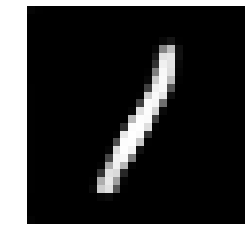

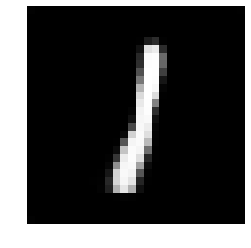

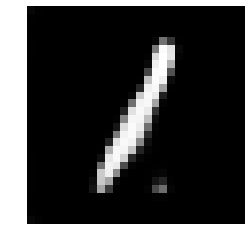

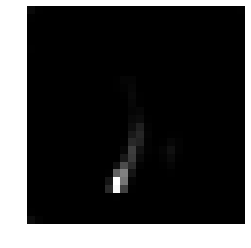

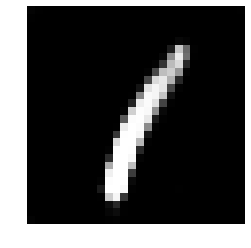

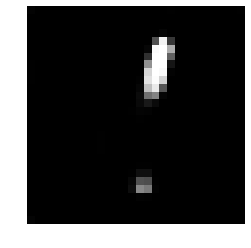

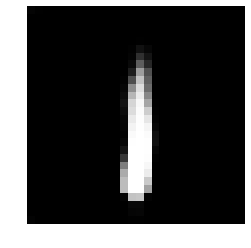

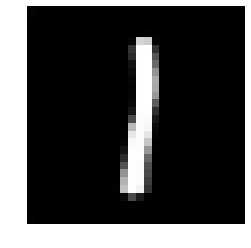

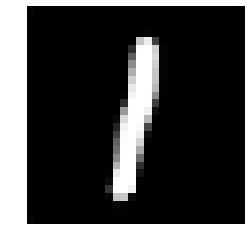

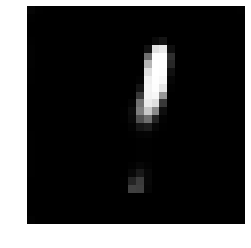

In [18]:
# Sample random points in the latent space
random_latent_vectors1 = np.random.normal(size=(10, latent_dim))

# Decode them to fake images
generated_images = generator1.predict(random_latent_vectors1)

for i in range(generated_images.shape[0]):
    img = image.array_to_img(generated_images[i] * 255., scale=False)
    plt.figure()
    plt.imshow(img, cmap = 'gray')
    plt.axis('off')
    
plt.show()

### Implication

Since GAN is pretty new technology, there hasn't been a lot of real-world applications of GAN. However, there are some possible, and maybe obvious, advantages and weaknesses from applying GAN into our reality. 

As for the advantages, people could augment the data, which are by nature, is very hard to acquire. The benefits from data augmentation could range from trivial to significant, but since GAN's application is not so widespread at this point, we can't be assured. As one of the examples, GAN could be used in drug invention. The generator would be trained with the sample drug candidates for a given disease in comparison with the existing drugs from a Drug Database. After the training, it might be possible to generate a drug for a previously incurable disease using the generator, and using the discriminator to determine whether the sampled drug actually cures the given disease. Such idea is shared by Anton Karazeev in his blog, https://blog.statsbot.co/generative-adversarial-networks-gans-engine-and-applications-f96291965b47.

As for the potential harms, GAN is vulnerable in wrong generalization. With the finite size discriminators and generators may not learn the distribution of predicted data very well, albeit the data training might seem successful. The distribution is produced by the generator supported on small number of data, which could be far from the distribution of the real data. The discriminator could use meaningless features to differentiate real data from the fake data. Therefore, it's very possible that the GAN could be vulnerable to sampling bias. Without the proper measure that measures the degree of bias, applying GAN hastely would lead to wrong generalization on data. 